In [1]:
import os
import datetime
import seaborn as sns
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/rl_sim/thesis_ws/src/ML/UTILITIES')
from PreProcessingFunctions import myfilter, num_transient, sliding_sum_window, select_index, add_padding
from PreProcessingFunctions import WS, WS_B
from PreProcessingFunctions import rename_and_convert_to_txt

from OrganizeReports import compare_and_organize
from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from ML_models_functions import to_save_model, save_summary_and_results

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, roc_auc_score

import tensorflow
from tensorflow.keras.models import save_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

tensorflow.config.list_physical_devices('GPU')
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
if gpus:    # Restrict TensorFlow to only allocate memory on the GPU dynamically
    for gpu in gpus:
        tensorflow.config.experimental.set_memory_growth(gpu, True)
    tensorflow.config.experimental.set_visible_devices(gpus[0], 'GPU')

from tensorflow.keras.models        import Sequential, Model, load_model
from tensorflow.keras.initializers  import GlorotUniform
from tensorflow.keras.layers        import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers        import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D
from tensorflow.keras.layers        import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers        import concatenate, Concatenate
from tensorflow.keras.optimizers    import Adam
from tensorflow.keras.losses        import BinaryCrossentropy
from tensorflow.keras.metrics       import AUC, Precision, Recall

from tensorflow.keras.utils         import plot_model


data_folder = '/home/rl_sim/thesis_ws/src/ML_ACTIONS/DATA/1D_TRANSF_LDG_FTP_ScalNorm'
WS_B = 3000

def load_data(data_folder):
    X_data = []
    y_data = []
    
    # Traverse the data folder
    for file in os.listdir(data_folder):
        if file.endswith(".npz"):
            file_path = os.path.join(data_folder, file)
            data = np.load(file_path)
            X_data.append(data['X'])
            y_data.append(data['y'])
    
    # Stack the data into arrays
    X_data = np.vstack(X_data)
    y_data = np.hstack(y_data)
    
    return X_data, y_data

# Load the data
X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)

X_data = np.dstack((X_data[:, :, 2], X_data[:, :, 0], X_data[:, :, 6], X_data[:, :, 7],X_data[:, :, 8]))    # TO DECOMMENT!
print("\nSelectedInputs: ", X_data.shape)
print("SelectedInputs: ", X_data[0].shape)

TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"\nTOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)
print("X_train shape:", X_train.shape)

IN_SHAPE = (WS_B, 5) #X_data[0].shape
TYPEm = "ANN_G"

2024-09-07 23:53:59.611507: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-07 23:53:59.637101: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-07 23:54:00.041649: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


X_data shape: (430, 3000, 9)
y_data shape: (430,)
X_data.[0] shape:  (3000, 9)

SelectedInputs:  (430, 3000, 5)
SelectedInputs:  (3000, 5)

TOTAL DATA: 430  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (258, 3000, 5)    ||  Dimensions of y_train: (258,)
Dimensions of X_test:  (86, 3000, 5)    ||  Dimensions of y_test:  (86,)
Dimensions of X_val:   (86, 3000, 5)    ||  Dimensions of y_val:   (86,)
X_train shape: (258, 3000, 5)


2024-09-07 23:54:00.350494: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-07 23:54:00.350656: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-07 23:54:00.374892: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# COMPLEX-BULKY FF-ANN

2024-09-07 19:35:41.423696: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-07 19:35:41.423902: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-07 19:35:41.424021: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3000, 5)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,840,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,945,764 (15.05 MB)

 Trainable params: 3,944,484 (15.05 MB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/25


I0000 00:00:1725730542.329895  297772 service.cc:145] XLA service 0x7fcb600109b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725730542.329931  297772 service.cc:153]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2024-09-07 19:35:42.372664: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-07 19:35:42.481806: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1/9 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.2812 - loss: 1.7483

I0000 00:00:1725730544.392929  297772 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - accuracy: 0.4429 - loss: 1.3955 - val_accuracy: 0.7326 - val_loss: 1.8048
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7414 - loss: 0.7137 - val_accuracy: 0.7674 - val_loss: 0.9148
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8311 - loss: 0.4994 - val_accuracy: 0.7791 - val_loss: 0.6586
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8183 - loss: 0.4386 - val_accuracy: 0.7791 - val_loss: 0.4925
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9022 - loss: 0.2977 - val_accuracy: 0.7558 - val_loss: 0.5453
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8287 - loss: 0.3985 - val_accuracy: 0.8023 - val_loss: 0.4770
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8727 - loss: 0.3455 - val_accuracy: 0.8372 - val_loss: 0.3489
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8800 - loss: 0.3111 - val_accuracy: 0.8721 - val_loss: 0.3024
Epoch 9/25
9/9 ━━

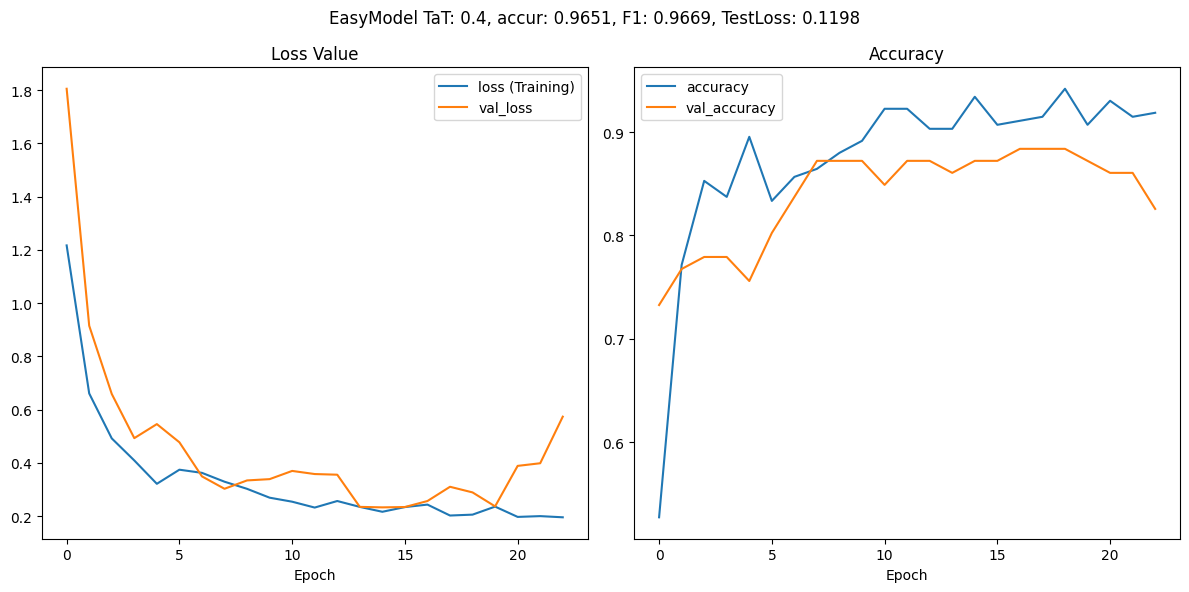

Train loss: 0.19523988664150238
Test val_loss: 0.5732018947601318
Train accuracy: 0.9186046719551086
Accuracy Score: 0.9651162790697675
F1 Score: 0.9668676561533704
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        17
         1.0       1.00      0.96      0.98        25
         2.0       0.95      0.91      0.93        23
         3.0       0.91      1.00      0.95        21

    accuracy                           0.97        86
   macro avg       0.97      0.97      0.97        86
weighted avg       0.97      0.97      0.97        86



ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (2).

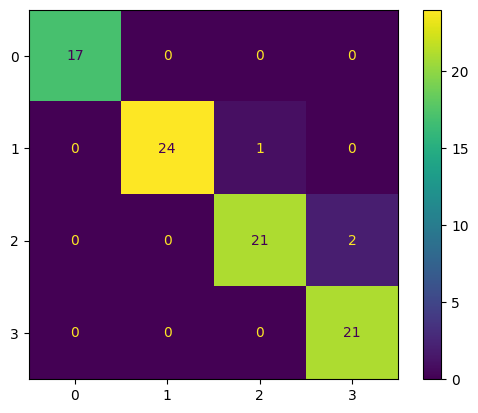

In [2]:

def build_ff_ann():
    inputs = Input(shape=IN_SHAPE)
    x = Flatten()(inputs)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(32, activation='relu')(x)
    outputs = Dense(4, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

model = build_ff_ann()
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping], verbose=1) 

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1) 

f1 = f1_score(y_test, y_pred_labels, average='macro')
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

plot_confusion_matrix(y_test, y_pred_labels)

In [ ]:
# model_name = f"FF_{TYPEm}_5LayerModel_v1"
# from ML_models_functions import save_summary_and_results
# save_summary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_binary, build_ff_ann)
# # Save the model separately
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# BRANCHED ANN

/home/rl_sim/anaconda3/envs/tfenv/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 3000, 5)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15000)     │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │  3,840,256 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 256)       │  3,840,256 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │  1,920,128 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │  1,920,128 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 256)       │          0 │ dense_13[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 64)        │    960,064 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256)       │          0 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     32,896 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      8,256 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 32)        │      2,080 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │     16,448 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 352)       │          0 │ dense_6[0][0],    │
│ (Concatenate)       │                   │            │ dense_8[0][0],    │
│                     │                   │            │ dense_10[0][0],   │
│                     │                   │            │ dense_12[0][0],   │
│                     │                   │            │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 352)       │      1,408 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 64)        │     22,592 │ batch_normalizat

 Total params: 12,574,052 (47.97 MB)

 Trainable params: 12,572,836 (47.96 MB)

 Non-trainable params: 1,216 (4.75 KB)

Epoch 1/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 463ms/step - accuracy: 0.5408 - loss: 1.0101 - val_accuracy: 0.6279 - val_loss: 2.2027
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8415 - loss: 0.4212 - val_accuracy: 0.7558 - val_loss: 2.2606
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8516 - loss: 0.3272 - val_accuracy: 0.7791 - val_loss: 1.0544
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8874 - loss: 0.2586 - val_accuracy: 0.7558 - val_loss: 0.9809
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9011 - loss: 0.2435 - val_accuracy: 0.7907 - val_loss: 1.0841
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9068 - loss: 0.2410 - val_accuracy: 0.8023 - val_loss: 0.7711
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9366 - loss: 0.1843 - val_accuracy: 0.8023 - val_loss: 0.5900
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9101 - loss: 0.2247 - val_accuracy: 0.8256 - val_loss: 0.5379
Epoch 

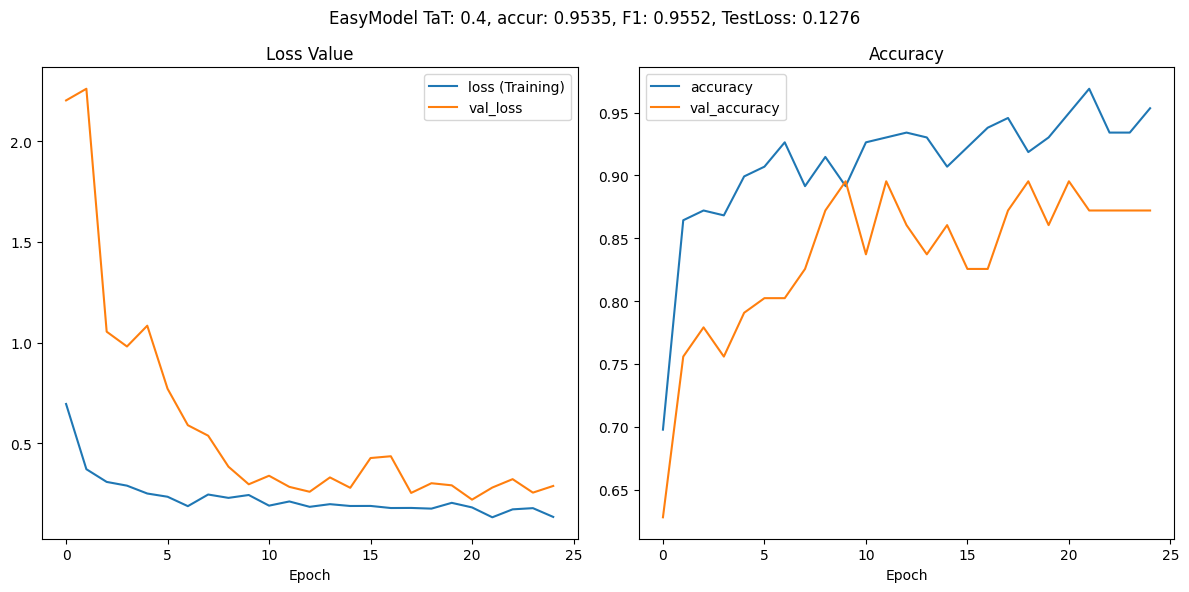

Train loss: 0.13456103205680847
Test val_loss: 0.28834497928619385
Train accuracy: 0.9534883499145508
Accuracy Score: 0.9534883720930233
F1 Score: 0.9552114552114552
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        17
         1.0       0.93      1.00      0.96        25
         2.0       1.00      0.83      0.90        23
         3.0       0.91      1.00      0.95        21

    accuracy                           0.95        86
   macro avg       0.96      0.96      0.96        86
weighted avg       0.96      0.95      0.95        86



ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (2).

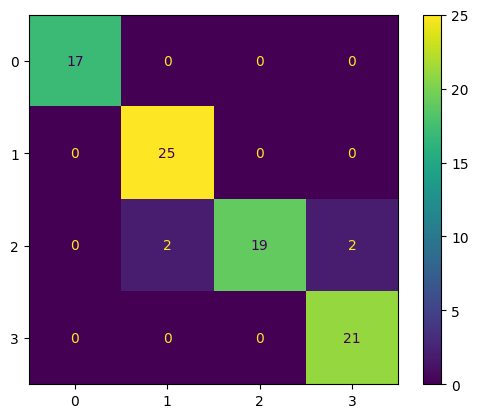

In [3]:
def build_ff_ann(input_shape=IN_SHAPE):
    input_layer = Input(shape=input_shape)
    flatten_layer = Flatten()(input_layer)
    
    # Branch 1
    branch1 = Dense(256, activation='relu')(flatten_layer)
    branch1 = BatchNormalization()(branch1)
    branch1 = Dropout(0.2)(branch1)
    branch1_output = Dense(128, activation='relu')(branch1)
    
    # Branch 2
    branch2 = Dense(128, activation='relu')(flatten_layer)
    branch2 = Dropout(0.2)(branch2)
    branch2_output = Dense(64, activation='relu')(branch2)
    
    # Branch 3
    branch3 = Dense(128, activation='relu')(flatten_layer)
    branch3 = Dropout(0.2)(branch3)
    branch3_output = Dense(64, activation='relu')(branch3)
    
    # Branch 4
    branch4 = Dense(64, activation='relu')(flatten_layer)
    branch4_output = Dense(32, activation='relu')(branch4)

    # Branch 5
    branch5 = Dense(256, kernel_initializer=GlorotUniform())(flatten_layer)
    branch5 = LeakyReLU(alpha=0.1)(branch5)
    branch5 = Dropout(0.2)(branch5)
    branch5_output = Dense(64, kernel_initializer=GlorotUniform(), activation='relu')(branch5)


    # Merge branches
    merged = concatenate([branch1_output, branch2_output, branch3_output, branch4_output, branch5_output])
    merged = BatchNormalization()(merged)
    merged = Dense(64, activation='relu')(merged)
    
    output_layer = Dense(4, activation='softmax')(merged)
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

model = build_ff_ann()
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping], verbose=1) 
loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1) 

f1 = f1_score(y_test, y_pred_labels, average='macro')
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

plot_confusion_matrix(y_test, y_pred_labels)

In [ ]:
# model_name = f"FF_{TYPEm}_BRANCHEDModel_v1"
# from ML_models_functions import save_summary_and_results
# save_summary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_binary, build_ff_ann)
# # Save the model separately
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# ARTICULATED BRANCH

/home/rl_sim/anaconda3/envs/tfenv/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 3000, 5)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 15000)     │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 256)       │  3,840,256 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_17[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 128)       │  1,920,128 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 128)       │  1,920,128 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128)       │          0 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 64)        │    960,064 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 128)       │     32,896 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 64)        │      8,256 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 64)        │      8,256 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 32)        │      2,080 │ dense_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 288)       │          0 │ dense_18[0][0],   │
│ (Concatenate)       │                   │            │ dense_20[0][0],   │
│                     │                   │            │ dense_22[0][0],   │
│                     │                   │            │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 288)       │      1,152 │ concatenate_1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 128)       │     36,992 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 64)        │      8,256 │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 64)        │      8,256 │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 64)        │      8,256 │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 64)        │          0 │ dense_30[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 8,769,092 (33.45 MB)

 Trainable params: 8,767,812 (33.45 MB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/25
1/9 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step - accuracy: 0.3438 - loss: 1.3859

I0000 00:00:1725730577.510930  302344 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_7', 8 bytes spill stores, 8 bytes spill loads



9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 645ms/step - accuracy: 0.4660 - loss: 1.2343 - val_accuracy: 0.4070 - val_loss: 3.1971
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7054 - loss: 0.7130 - val_accuracy: 0.5465 - val_loss: 1.7008
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7733 - loss: 0.5371 - val_accuracy: 0.5581 - val_loss: 1.0373
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8263 - loss: 0.4690 - val_accuracy: 0.6279 - val_loss: 0.7243
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8587 - loss: 0.4004 - val_accuracy: 0.7907 - val_loss: 0.4436
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8414 - loss: 0.3825 - val_accuracy: 0.8023 - val_loss: 0.4197
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8614 - loss: 0.3292 - val_accuracy: 0.7791 - val_loss: 0.4259
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8689 - loss: 0.3643 - val_accuracy: 0.8023 - val_loss: 0.3849
Epoch 9/25
9/9 ━

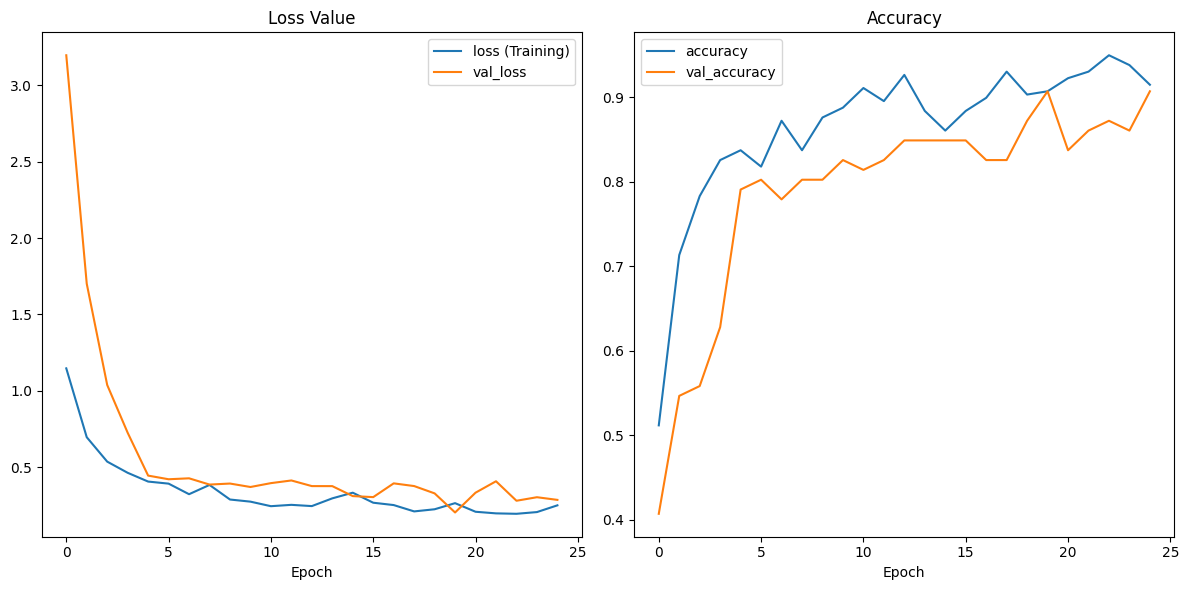

Train loss: 0.24886244535446167
Test val_loss: 0.28463029861450195
Train accuracy: 0.9147287011146545
Accuracy Score: 0.9186046511627907
F1 Score: 0.9199239107775693
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        17
         1.0       0.93      1.00      0.96        25
         2.0       0.94      0.74      0.83        23
         3.0       0.83      0.95      0.89        21

    accuracy                           0.92        86
   macro avg       0.93      0.92      0.92        86
weighted avg       0.92      0.92      0.92        86



ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (2).

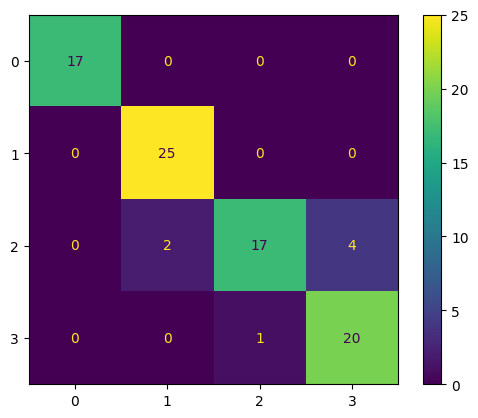

In [4]:
from tensorflow.keras.initializers import GlorotUniform

def build_ff_ann(input_shape=IN_SHAPE):
    input_layer = Input(shape=input_shape)
    flatten_layer = Flatten()(input_layer)  # Add a flatten layer
    
    # Branch 1
    branch1 = Dense(256, activation='relu')(flatten_layer)
    branch1 = BatchNormalization()(branch1)
    branch1 = Dropout(0.2)(branch1)
    branch1_output = Dense(128, activation='relu')(branch1)
    
    # Branch 2
    branch2 = Dense(128, activation='relu')(flatten_layer)
    branch2 = Dropout(0.2)(branch2)
    branch2_output = Dense(64, activation='relu')(branch2)
    
    # Branch 3
    branch3 = Dense(128, activation='relu')(flatten_layer)
    branch3 = Dropout(0.2)(branch3)
    branch3_output = Dense(64, activation='relu')(branch3)
    
    # Branch 4
    branch4 = Dense(64, activation='relu')(flatten_layer)
    branch4_output = Dense(32, activation='relu')(branch4)

    # Merge the first four branches
    merged = concatenate([branch1_output, branch2_output, branch3_output, branch4_output])
    merged = BatchNormalization()(merged)
    merged = Dense(128, activation='relu')(merged)
    
    # Split into three new branches
    branch5 = Dense(64, activation='relu')(merged)
    branch5 = Dropout(0.2)(branch5)
    branch5_output = Dense(32, activation='relu')(branch5)
    
    branch6 = Dense(64, activation='relu')(merged)
    branch6 = Dropout(0.2)(branch6)
    branch6_output = Dense(32, activation='relu')(branch6)
    
    branch7 = Dense(64, kernel_initializer=GlorotUniform())(merged)
    branch7 = LeakyReLU(alpha=0.1)(branch7)
    branch7 = Dropout(0.2)(branch7)
    branch7_output = Dense(32, kernel_initializer=GlorotUniform(), activation='relu')(branch7)
    
    # Merge the three branches
    final_merge = concatenate([branch5_output, branch6_output, branch7_output])
    final_merge = BatchNormalization()(final_merge)
    final_merge = Dense(64, activation='relu')(final_merge)
    
    # Output layer
    output_layer = Dense(4, activation='softmax')(final_merge)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

# To create the model
model = build_ff_ann()
model.summary()

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping], verbose=1) 
loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1) 

f1 = f1_score(y_test, y_pred_labels, average='macro')
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

plot_confusion_matrix(y_test, y_pred_labels)

In [ ]:
# model_name = f"FF_{TYPEm}_ArticulatedModel_v1"
# from ML_models_functions import save_summary_and_results
# save_summary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_binary, build_ff_ann)
# # Save the model separately
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# M_I, M_B

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 3000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 3000, 3)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 6000)      │          0 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 9000)      │          0 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input4 (InputLayer) │ (None, 3000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 256)       │  1,536,256 │ flatten_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 512)       │  4,608,512 │ flatten_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 3000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 6000)      │          0 │ input4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_16[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_18[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 512)       │  1,536,512 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 256)       │  1,536,256 │ flatten_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 512)       │    131,584 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 256)       │    131,328 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_20[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 128)       │     32,896 │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 512)       │          0 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 256)       │          0 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 128)       │     65,664 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128)       │          0 │ dense_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 1024)      │          0 │ dropout_6[0][0],  │
│ (Concatenate)       │                   │            │ dropout_7[0][0],  │
│                     │                   │            │ dense_21[0][0],   │
│                     │                   │            │ dropout_8[0][0] 

 Total params: 9,720,100 (37.08 MB)

 Trainable params: 9,717,284 (37.07 MB)

 Non-trainable params: 2,816 (11.00 KB)

Epoch 1/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 336ms/step - accuracy: 0.5530 - loss: 1.0440 - val_accuracy: 0.3837 - val_loss: 5.2137
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8397 - loss: 0.4519 - val_accuracy: 0.6860 - val_loss: 0.9341
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8695 - loss: 0.3935 - val_accuracy: 0.8256 - val_loss: 0.5703
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8796 - loss: 0.3439 - val_accuracy: 0.8372 - val_loss: 0.4479
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9322 - loss: 0.2650 - val_accuracy: 0.8023 - val_loss: 0.6122
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9189 - loss: 0.2791 - val_accuracy: 0.6512 - val_loss: 0.8771
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8948 - loss: 0.2905 - val_accuracy: 0.8140 - val_loss: 0.6561
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9374 - loss: 0.2070 - val_accuracy: 0.7558 - val_loss: 0.7726
Epoch 

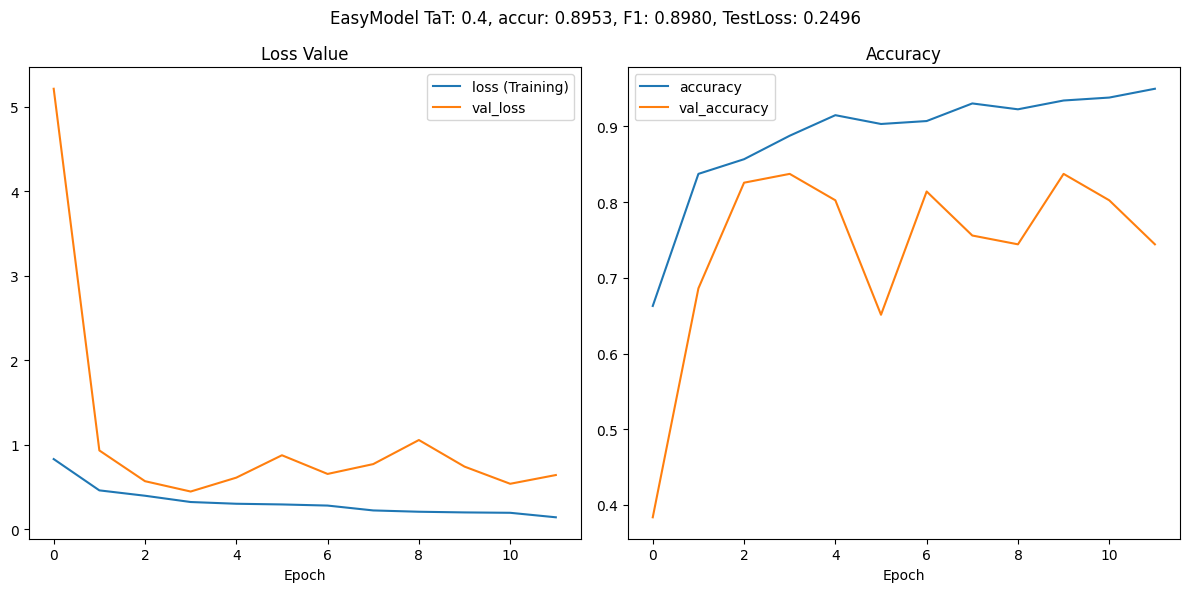

Train loss: 0.14308586716651917
Test val_loss: 0.6430782079696655
Train accuracy: 0.9496123790740967
Accuracy Score: 0.8953488372093024
F1 Score: 0.8980394605394606
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.94      0.97        17
         1.0       0.81      1.00      0.89        25
         2.0       1.00      0.70      0.82        23
         3.0       0.87      0.95      0.91        21

    accuracy                           0.90        86
   macro avg       0.92      0.90      0.90        86
weighted avg       0.91      0.90      0.89        86



ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (2).

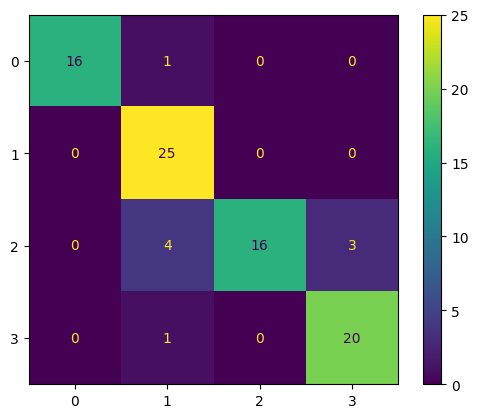

In [4]:
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Dropout, LeakyReLU, Concatenate, ReLU
from tensorflow.keras.models import Model

def build_ff_ann():
    # Input branches
    in1 = Input(shape=(WS_B, 2), name='input1')  # Example of a 2D input that needs flattening
    in2 = Input(shape=(WS_B, 3), name='input2')  # Another 2D input
    in3 = Input(shape=(WS_B,), name='input3')    # 1D input, no flattening needed
    in4 = Input(shape=(WS_B, 2), name='input4')  # 2D input

    # Branch 1 (in1): Flatten + more layers
    b1 = Flatten()(in1)
    b1 = Dense(256, activation='relu')(b1)
    b1 = BatchNormalization()(b1)
    b1 = Dense(512, activation='relu')(b1)
    b1 = Dropout(0.2)(b1)

    # Branch 2 (in3): No flatten needed, small layers (previously Branch 3)
    b2 = Flatten()(in2)
    b2 = Dense(512, activation='relu')(b2)
    b2 = BatchNormalization()(b2)
    b2 = Dense(256, activation='relu')(b2)
    b2 = Dropout(0.1)(b2)

    # Branch 3 (in2): Flatten + fewer layers, larger size (previously Branch 2)
    b3 = Dense(512, activation='relu')(in3)
    b3 = BatchNormalization()(b3)
    b3 = Dense(128, activation='relu')(b3)

    # Branch 4 (in4): Flatten + medium layers
    b4 = Flatten()(in4)
    b4 = Dense(256, activation='relu')(b4)
    b4 = Dense(128, activation='relu')(b4)
    b4 = Dropout(0.1)(b4)

    # Concatenate all branches
    combined = Concatenate(name='concat')([b1, b2, b3, b4])

    # Dense layers after concatenation
    b = Dense(128, activation='relu', name='dense1')(combined)
    b = BatchNormalization()(b)
    b = Dense(32, activation='relu', name='dense2')(b)
    outputs = Dense(4, activation='softmax', name='output')(b)

    # Define the model with multiple inputs
    model = Model(inputs=[in1, in2, in3, in4], outputs=outputs)
    return model

# Example usage
model = build_ff_ann()
model.summary()

X_data, y_data = load_data(data_folder)
TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train_ = [np.dstack((X_train[:, :, 0], X_train[:,:, 2])), 
            np.dstack((X_train[:, :, 8], X_train[:,:, 6], X_train[:,:, 5])), 
            X_train[:, :, 2], 
            np.dstack((X_train[:, :, 2], X_train[:,:, 8]))]

X_val_ = [np.dstack((X_val[:, :, 0], X_val[:,:, 2])), 
          np.dstack((X_val[:, :, 8], X_val[:,:, 6], X_val[:,:, 5])), 
          X_val[:, :, 2], 
          np.dstack((X_val[:, :, 2], X_val[:,:, 8]))]

X_test_ = [np.dstack((X_test[:, :, 0], X_test[:,:, 2])), 
           np.dstack((X_test[:, :, 8], X_test[:,:, 6], X_test[:,:, 5])), 
           X_test[:, :, 2], 
           np.dstack((X_test[:, :, 2], X_test[:,:, 8]))]

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train_, y_train, epochs=25, batch_size=32, validation_data=(X_val_, y_val), 
                    callbacks=[early_stopping], verbose=1) 
loss, accuracy = model.evaluate(X_test_, y_test)

# Predict labels for test data
y_pred = model.predict(X_test_)
y_pred_labels = np.argmax(y_pred, axis=1) 

f1 = f1_score(y_test, y_pred_labels, average='macro')
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

plot_confusion_matrix(y_test, y_pred_labels)

In [ ]:
# import os
# from tensorflow.keras.models import save_model
# TYPEm = "ANN_G"
# model_name = f"FF_{TYPEm}_MultInMulB_v1"
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

## 9B individual

2024-09-07 22:39:35.286026: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-07 22:39:35.286328: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-07 22:39:35.286528: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "multi_input_ff_ann"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_3             │ (None, 3000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_9             │ (None, 3000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch_3_dense_1    │ (None, 512)       │  1,536,512 │ input_3[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch_9_dense_1    │ (None, 512)       │  1,536,512 │ input_9[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch_3_bn_1       │ (None, 512)       │      2,048 │ branch_3_dense_1… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch_9_bn_1       │ (None, 512)       │      2,048 │ branch_9_dense_1… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_1             │ (None, 3000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_2             │ (None, 3000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch_3_dense_2    │ (None, 512)       │    262,656 │ branch_3_bn_1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_4             │ (None, 3000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_5             │ (None, 3000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_6             │ (None, 3000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_7             │ (None, 3000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_8             │ (None, 3000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch_9_dense_2    │ (None, 512)       │    262,656 │ branch_9_bn_1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch_1_dense_1    │ (None, 256)       │    768,256 │ input_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch_2_dense_1    │ (None, 256)       │    768,256 │ input_2[0][0]   

 Total params: 9,846,820 (37.56 MB)

 Trainable params: 9,842,468 (37.55 MB)

 Non-trainable params: 4,352 (17.00 KB)

Epoch 1/25


I0000 00:00:1725741578.224774  337755 service.cc:145] XLA service 0x7fa824035af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725741578.224799  337755 service.cc:153]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2024-09-07 22:39:38.308474: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-07 22:39:38.679128: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1725741579.998306  337847 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5258', 4 bytes spill stores, 4 bytes spill loads



1/9 ━━━━━━━━━━━━━━━━━━━━ 50s 6s/step - accuracy: 0.1562 - loss: 1.8364

I0000 00:00:1725741581.965796  337755 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_22', 12 bytes spill stores, 12 bytes spill loads

I0000 00:00:1725741581.972653  337755 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.5273 - loss: 1.1542

I0000 00:00:1725741585.691252  337756 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_36', 12 bytes spill stores, 12 bytes spill loads



9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 663ms/step - accuracy: 0.5424 - loss: 1.1186 - val_accuracy: 0.6628 - val_loss: 18.0466
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8194 - loss: 0.4197 - val_accuracy: 0.5698 - val_loss: 32.9055
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8938 - loss: 0.2977 - val_accuracy: 0.4535 - val_loss: 24.5764
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8836 - loss: 0.2871 - val_accuracy: 0.6744 - val_loss: 11.0939
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8790 - loss: 0.3220 - val_accuracy: 0.6628 - val_loss: 6.0919
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8698 - loss: 0.3071 - val_accuracy: 0.6628 - val_loss: 4.5967
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8818 - loss: 0.3246 - val_accuracy: 0.7907 - val_loss: 0.8658
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8709 - loss: 0.2959 - val_accuracy: 0.7674 - val_loss: 0.9952
Epoch 9/25
9

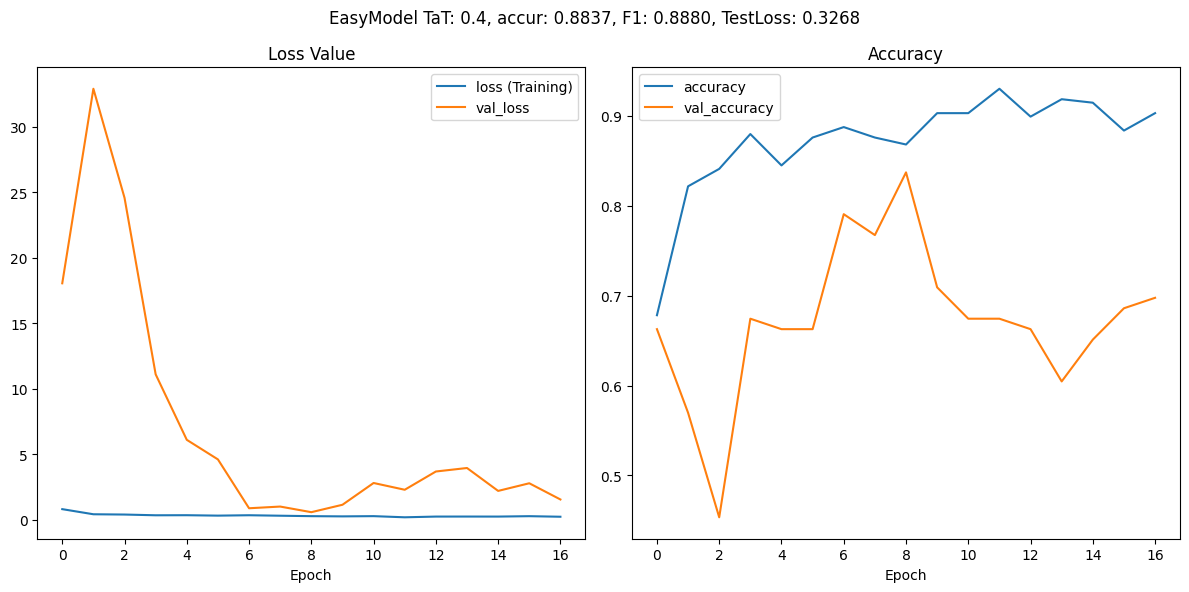

Train loss: 0.21786648035049438
Test val_loss: 1.537083625793457
Train accuracy: 0.9031007885932922
Accuracy Score: 0.8837209302325582
F1 Score: 0.8880386067886068
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.94      0.97        17
         1.0       0.86      1.00      0.93        25
         2.0       0.76      0.83      0.79        23
         3.0       1.00      0.76      0.86        21

    accuracy                           0.88        86
   macro avg       0.91      0.88      0.89        86
weighted avg       0.90      0.88      0.88        86



ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (2).

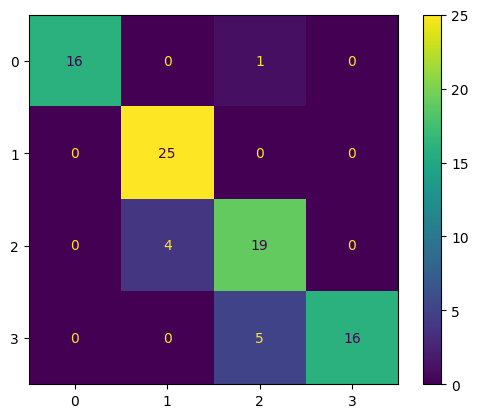

In [2]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Concatenate, ReLU
from tensorflow.keras.models import Model

def build_ff_ann():
    # Define the input shape
    input_shape = (3000,) #(800,)
    
    # Define each of the 9 branches
    branches = []
    inputs = []

    for i in range(1, 10):
        inp = Input(shape=input_shape, name=f'input_{i}')
        inputs.append(inp)
        
        if i == 3 or i == 9:  # More articulated branches (4 layers)
            b = Dense(512, activation='relu', name=f'branch_{i}_dense_1')(inp)
            b = BatchNormalization(name=f'branch_{i}_bn_1')(b)
            b = Dense(512, activation='relu', name=f'branch_{i}_dense_2')(b)
            b = Dropout(0.1, name=f'branch_{i}_dropout_1')(b)
            b = Dense(256, activation='relu', name=f'branch_{i}_dense_3')(b)
            b = Dropout(0.1, name=f'branch_{i}_dropout_2')(b)
            
        else:  # Basic branches (2 layers)
            b = Dense(256, activation='relu', name=f'branch_{i}_dense_1')(inp)          
            b = Dense(128, activation='relu', name=f'branch_{i}_dense_2')(b)
            b = BatchNormalization(name=f'branch_{i}_bn_1')(b)
        
        branches.append(b)
    
    # Merge all branches
    merged = Concatenate(name='merged_branches')(branches)
    
    # Additional dense layers after merging
    x = Dense(256, activation='relu', name='merged_dense_1')(merged)
    x = BatchNormalization(name='merged_bn_1')(x)
    x = Dense(32, activation='relu', name='merged_dense_2')(x)
    
    # Final output layer
    output = Dense(4, activation='softmax', name='output')(x)
    
    # Define the model with 9 inputs
    model = Model(inputs=inputs, outputs=output, name='multi_input_ff_ann')
    return model

# Example usage
model = build_ff_ann()
model.summary()

X_data, y_data = load_data(data_folder)
TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train_ = [X_train[:, :, i] for i in range(9)]
X_val_ = [X_val[:, :, i] for i in range(9)]
X_test_ = [X_test[:, :, i] for i in range(9)]

model.compile(optimizer=Adam(learning_rate=0.004), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train_, y_train, epochs=25, batch_size=32, validation_data=(X_val_, y_val), 
                    callbacks=[early_stopping], verbose=1) 
loss, accuracy = model.evaluate(X_test_, y_test)

# Predict labels for test data
y_pred = model.predict(X_test_)
y_pred_labels = np.argmax(y_pred, axis=1) 

f1 = f1_score(y_test, y_pred_labels, average='macro')
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

plot_confusion_matrix(y_test, y_pred_labels)

# PRECISION METRICS

In [21]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def build_ff_ann():
    # Define the input shape
    input_shape = (3000,) #(800,)
    
    # Define each of the 9 branches
    branches = []
    inputs = []

    for i in range(1, 10):
        inp = Input(shape=input_shape, name=f'input_{i}')
        inputs.append(inp)
        
        if i == 3 or i == 9:  # More articulated branches (4 layers)
            b = Dense(512, activation='relu', name=f'branch_{i}_dense_1')(inp)
            b = BatchNormalization(name=f'branch_{i}_bn_1')(b)
            b = Dense(512, activation='relu', name=f'branch_{i}_dense_2')(b)
            b = Dropout(0.1, name=f'branch_{i}_dropout_1')(b)
            b = Dense(256, activation='relu', name=f'branch_{i}_dense_3')(b)
            b = Dropout(0.1, name=f'branch_{i}_dropout_2')(b)
            
        else:  # Basic branches (2 layers)
            b = Dense(256, activation='relu', name=f'branch_{i}_dense_1')(inp)          
            b = Dense(128, activation='relu', name=f'branch_{i}_dense_2')(b)
            b = BatchNormalization(name=f'branch_{i}_bn_1')(b)
        
        branches.append(b)
    
    # Merge all branches
    merged = Concatenate(name='merged_branches')(branches)
    
    # Additional dense layers after merging
    x = Dense(256, activation='relu', name='merged_dense_1')(merged)
    x = BatchNormalization(name='merged_bn_1')(x)
    x = Dense(32, activation='relu', name='merged_dense_2')(x)
    
    # Final output layer
    output = Dense(4, activation='softmax', name='output')(x)
    
    # Define the model with 9 inputs
    model = Model(inputs=inputs, outputs=output, name='multi_input_ff_ann')
    return model

# Example usage
model = build_ff_ann()
model.summary()

X_data, y_data = load_data(data_folder)
TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train_ = [X_train[:, :, i] for i in range(9)]
X_val_ = [X_val[:, :, i] for i in range(9)]
X_test_ = [X_test[:, :, i] for i in range(9)]

# Use Precision as the metric
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', 
              metrics=['precision'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train_, y_train, epochs=40, batch_size=32, validation_data=(X_val_, y_val), 
                    callbacks=[early_stopping], verbose=1) 
loss, precision_train = model.evaluate(X_test_, y_test)

# Predict labels for test data
y_pred = model.predict(X_test_)
y_pred_labels = np.argmax(y_pred, axis=1) 

precision = precision_score(y_test, y_pred_labels, average='macro')

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Precision
axs[1].plot(history.history["precision"], label="precision")
axs[1].plot(history.history["val_precision"], label="val_precision")
axs[1].set_title("Precision")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, Precision: {precision:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train precision:", history.history["precision"][-1])

print("Precision Score (on test set):", precision)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

plot_confusion_matrix(y_test, y_pred_labels)


Model: "multi_input_ff_ann"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_3             │ (None, 3000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_9             │ (None, 3000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch_3_dense_1    │ (None, 512)       │  1,536,512 │ input_3[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch_9_dense_1    │ (None, 512)       │  1,536,512 │ input_9[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch_3_bn_1       │ (None, 512)       │      2,048 │ branch_3_dense_1… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch_9_bn_1       │ (None, 512)       │      2,048 │ branch_9_dense_1… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_1             │ (None, 3000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_2             │ (None, 3000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch_3_dense_2    │ (None, 512)       │    262,656 │ branch_3_bn_1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_4             │ (None, 3000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_5             │ (None, 3000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_6             │ (None, 3000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_7             │ (None, 3000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_8             │ (None, 3000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch_9_dense_2    │ (None, 512)       │    262,656 │ branch_9_bn_1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch_1_dense_1    │ (None, 256)       │    768,256 │ input_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch_2_dense_1    │ (None, 256)       │    768,256 │ input_2[0][0]   

 Total params: 9,846,820 (37.56 MB)

 Trainable params: 9,842,468 (37.55 MB)

 Non-trainable params: 4,352 (17.00 KB)

Epoch 1/25


2024-09-07 20:12:22.096809: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at xla_ops.cc:580 : INVALID_ARGUMENT: Incompatible shapes: [1,32] vs. [1,128]
	 [[{{node LogicalAnd}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_171965[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
2024-09-07 20:12:22.096861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [1,32] vs. [1,128]
	 [[{{node LogicalAnd}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_171965[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]]


InvalidArgumentError: Graph execution error:

Detected at node LogicalAnd defined at (most recent call last):
<stack traces unavailable>
Incompatible shapes: [1,32] vs. [1,128]
	 [[{{node LogicalAnd}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_171965[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_iterator_172426]

In [ ]:
# import os
# from tensorflow.keras.models import save_model
# TYPEm = "ANN_G"
# model_name = f"FF_{TYPEm}_1IN_9B"
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)